In [1]:
!gsutil cp gs://chem_dsrc/Credit_card_overdue_prediction/dataset.zip ./
!unzip dataset.zip

Copying gs://chem_dsrc/Credit_card_overdue_prediction/dataset.zip...
/ [1 files][704.6 KiB/704.6 KiB]                                                
Operation completed over 1 objects/704.6 KiB.                                    
Archive:  dataset.zip
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       


# **라이브러리 불러오기**

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

     |████████████████████████████████| 67.3MB 127kB/s 


In [4]:
import os
os.chdir('./dataset')

In [5]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

# **[데이터 살펴보기]**

In [6]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [7]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [8]:
train.shape

(26457, 20)

In [9]:
test.shape

(10000, 19)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [50]:
features15= ['gender', 'car', 'reality', 'phone', 'email', 'work_phone', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']

In [51]:
set(list(train.columns)) - set(features15)

{'FLAG_MOBIL', 'credit', 'family_size', 'index', 'occyp_type'}

## 18 features, target : credit

###6 binary variables
gender, car, reality, phone, email, work_phone

###9 contiuous variables
child_num,

income_total

income_type, edu_type, family_type, house_type : Type 

DAYS_BIRTH, DAYS_EMPLOYED , begin_month

### 3 variables
'FLAG_MOBIL', 'family_size', 'occyp_type'

In [52]:
train.FLAG_MOBIL.value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

In [53]:
train.family_size.value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [54]:
train.occyp_type.value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

# **[데이터 전처리]**

In [12]:
data=pd.concat([train, test], axis=0)
data.shape

(36457, 20)

## **1. 결측치 제거** 

In [14]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
credit           10000
dtype: int64

In [ ]:
data=data.drop('occyp_type', axis=1)

In [ ]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
family_size          0
begin_month          0
credit           10000
dtype: int64

## **2. Binary variables**

In [15]:
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


## **3. Continuous variable**

### (1) child_num

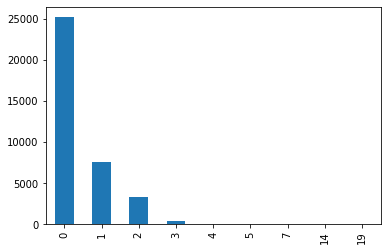

In [16]:
data['child_num'].value_counts(sort=False).plot.bar()

In [17]:
data.loc[data['child_num'] >= 2,'child_num']=2

In [20]:
data.child_num.value_counts()

0    25201
1     7492
2     3764
Name: child_num, dtype: int64

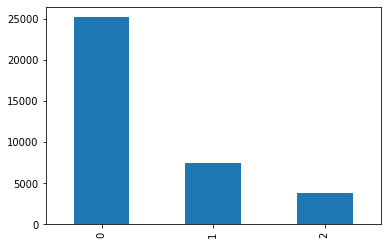

In [21]:
data['child_num'].value_counts(sort=False).plot.bar()

### (2) inc

(-0.000745, 0.00182]    22460
(0.00182, 0.00337]      11380
(0.00337, 0.00491]       2099
(0.00491, 0.00646]        274
(0.00646, 0.00801]        165
(0.00801, 0.00956]         58
(0.00956, 0.0111]           4
(0.0111, 0.0127]            3
(0.0127, 0.0142]            6
(0.0142, 0.0158]            8
Name: income_total, dtype: int64


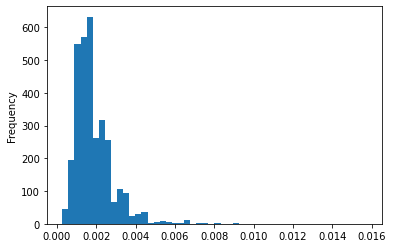

In [23]:
data['income_total'] = data['income_total'].astype(object)
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False)) # bin : Rather than count values, group them into half-open bins, a convenience for pd.cut, only works with numeric data.
data['income_total'].plot(kind='hist',bins=50,density=True)

In [24]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [29]:
data.income_total.value_counts() # 범주형으로 변경후 결과

소득0    29852
소득1     6071
소득2      413
소득3       96
소득4       11
소득6        8
소득5        6
Name: income_total, dtype: int64

### **(3) Type**

In [30]:
print(data['income_type'].unique())
print(data['edu_type'].unique())
print(data['family_type'].unique())
print(data['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [31]:
#type은 label-encoding을 이용.
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])

In [33]:
data['income_type'].value_counts()

4    18819
0     8490
1     6152
2     2985
3       11
Name: income_type, dtype: int64

## **4. Minus continuous variable**

In [34]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    data[variable]=-data[variable]
    count, bin_dividers =np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data[variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data[variable]=label_encoder.fit_transform(data[variable])

In [35]:
data.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [36]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [37]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,3,1,1,0,0,0,NaN,2.0,0,1.0
1,1,0,0,1,1,0,0,4,0,1,2,1,1,0,0,1,Laborers,3.0,0,1.0
2,2,1,1,1,0,1,4,1,1,1,6,1,1,0,1,0,Managers,2.0,1,2.0
3,3,0,0,1,0,0,0,4,1,1,4,1,1,0,1,0,Sales staff,2.0,2,0.0
4,4,0,1,1,0,0,2,1,1,1,4,1,1,0,0,0,Managers,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,4,2,1,1,6,1,1,1,1,0,Accountants,2.0,1,NaN
9996,36453,1,1,1,0,0,4,4,0,1,1,1,1,1,0,0,Laborers,2.0,2,NaN
9997,36454,0,0,1,0,1,4,4,1,1,7,1,1,0,0,0,Medicine staff,2.0,3,NaN
9998,36455,0,1,0,0,0,0,4,1,1,5,1,1,0,1,0,NaN,2.0,2,NaN


# **[데이터 모델링]**

In [38]:
len(data)

36457

In [39]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [40]:
train.shape

(26457, 20)

In [41]:
test.shape

(10000, 20)

In [42]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [43]:
print(train_x.shape, train_y.shape, test_x.shape)

(26457, 19) (26457, 1) (10000, 19)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 1.0330831266513165


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.0637261617402325
FOLD 1 : logloss:1.0540148690371987
FOLD 2 : logloss:1.114982477892243
FOLD 3 : logloss:1.0354563831233161
FOLD 4 : logloss:1.0692575976729684
Mean:1.0674874978931916


In [ ]:
my_submission

array([[0.106, 0.188, 0.706],
       [0.086, 0.294, 0.62 ],
       [0.082, 0.292, 0.626],
       ...,
       [0.064, 0.12 , 0.816],
       [0.108, 0.384, 0.508],
       [0.108, 0.332, 0.56 ]])

In [ ]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.106,0.188,0.706
1,26458,0.086,0.294,0.620
2,26459,0.082,0.292,0.626
3,26460,0.108,0.202,0.690
4,26461,0.142,0.376,0.482
...,...,...,...,...
9995,36452,0.128,0.356,0.516
9996,36453,0.118,0.378,0.504
9997,36454,0.064,0.120,0.816
9998,36455,0.108,0.384,0.508


In [ ]:
os.chdir('../baseline')

In [ ]:
submission.to_csv('baseline_submission.csv', index=False)